# Credit card fraud

The aim of this project was to build model predicting if the credit card transaction is a fraud.

In [23]:
import pandas as pd
import numpy as np
np.random.seed(2019)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import  learning_curve, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.base import clone

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve

from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import zipfile
import os
os.getcwd()

import warnings
warnings.filterwarnings('ignore')

### Data loading 

In [3]:
FRAUD_PATH = os.path.join("FRAUD", "DATA")
FILE_PATH = os.path.join(os.getcwd(), "creditcardfraud.zip")

def extract_data(fraud_path=FRAUD_PATH, file_path=FILE_PATH):
    if not os.path.isdir(fraud_path):
        os.makedirs(fraud_path)
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(fraud_path)

In [4]:
extract_data()

In [5]:
FRAUD_PATH = os.path.join("FRAUD", "DATA")
path=os.path.join(FRAUD_PATH, 'creditcard.csv')

df=pd.read_csv(path)

### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
df.isnull().any().any()

False

In [8]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
246949,153399.0,2.016159,-1.015916,-1.809951,-0.407078,1.494080,4.040835,-1.444851,1.004104,-0.264494,...,-0.002875,0.527688,0.111028,0.679130,0.052831,-0.356448,0.093513,-0.034238,30.00,0
125600,77729.0,1.306700,0.213456,-0.109044,-0.034889,-0.027178,-1.012244,0.394255,-0.345366,-0.181242,...,-0.456311,-1.352091,0.121974,-0.079709,0.193579,0.648696,-0.098183,0.003329,22.50,0
248082,153789.0,2.189292,-0.663296,-1.418668,-1.096806,-0.233084,-0.692229,-0.389778,-0.254238,-0.965586,...,0.493695,1.421238,0.000954,0.853217,0.223169,0.009137,-0.041107,-0.065917,15.00,0
253398,156232.0,-0.706309,0.779612,0.920347,0.997024,1.364367,-0.824400,1.570090,-0.494929,-0.919825,...,0.058125,0.332196,-0.503240,0.008304,1.115720,-0.215106,-0.143139,-0.163528,41.39,0
222876,143152.0,0.232695,0.847044,-0.308458,-0.500006,0.892295,-0.654689,0.937207,-0.307682,-0.023858,...,0.351125,1.132289,-0.291230,-0.722070,-0.301914,-0.121702,0.002894,0.092798,1.00,0


In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Target variable

In [12]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [13]:
print('Percent of fraud transactions: {} %'.format(round(df['Class'].value_counts(normalize=True)[1]*100,2)))

Percent of fraud transactions: 0.17 %


Data set is highly imbalanced. Appropriate techniques to ensure proper model designing and validation should be applied.
Data is anonimized, the structure looks like the result of reduction technique like PCA. Only the amount and time of transaction are visible, rest of features are anonimized and transformed. 

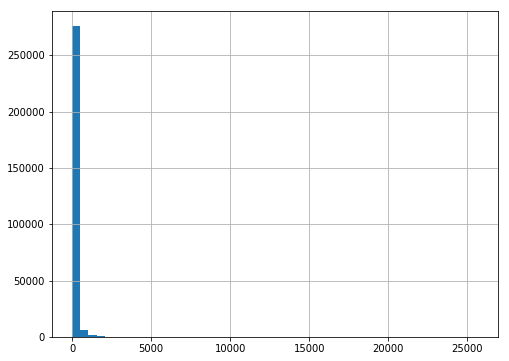

In [14]:
df['Amount'].hist(bins=50,figsize=(8,6))

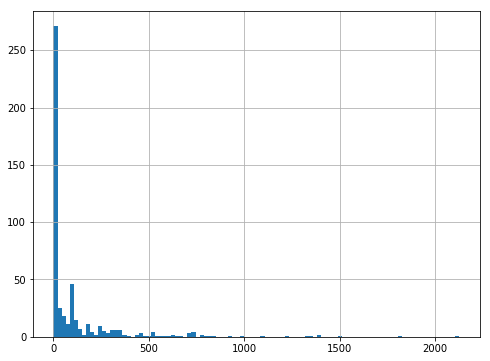

In [15]:
df[df['Class']==1]['Amount'].hist(bins=100,figsize=(8,6))

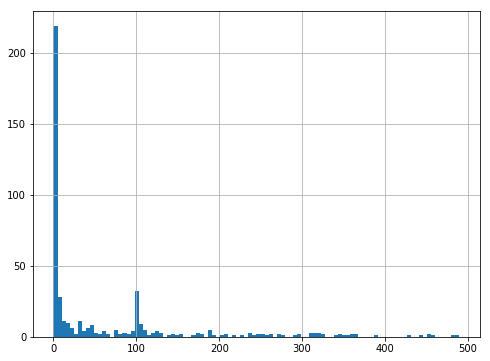

In [16]:
df[(df['Class']==1)&(df['Amount']<500)]['Amount'].hist(bins=100,figsize=(8,6))

It is visible that fraud transactions concerncs relatively small values. 

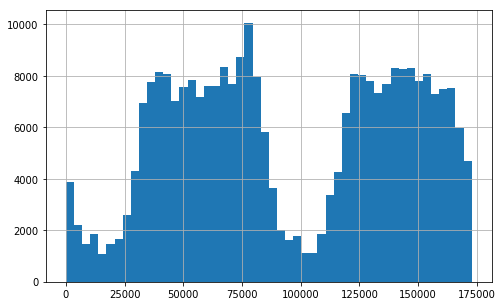

In [17]:
df['Time'].hist(bins=50,figsize=(8,5))

Taking into consideration that we have approximately 175 000 values it looks like the data concerns transactions from two days. 
Visualization shows that the number of transactions is relatively small at some time windows. 

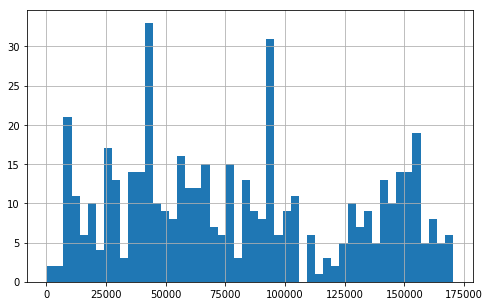

In [18]:
df[df['Class']==1]['Time'].hist(bins=50,figsize=(8,5))

We can see some peaks of the number of fraud transaction in time.

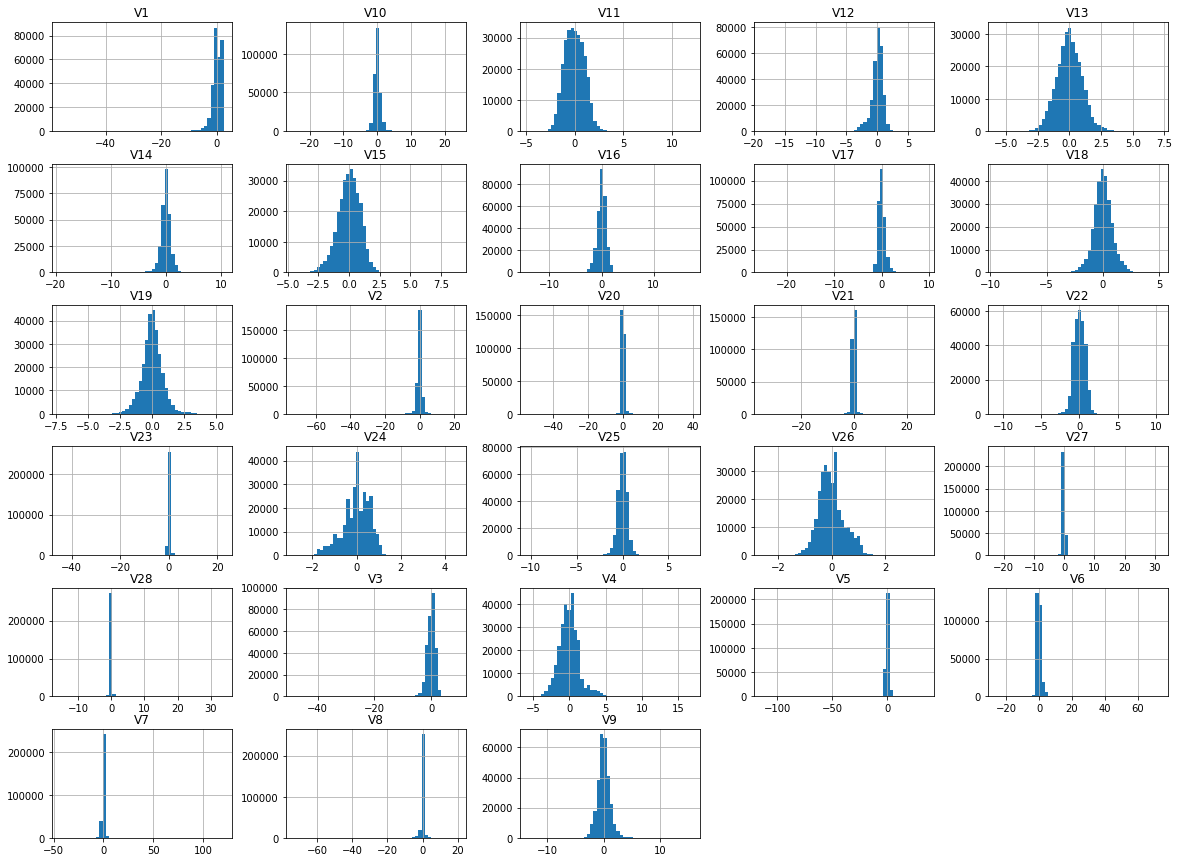

In [19]:
c=[x for x in df.columns if x not in ['Amount','Class','Time']]
df[c].hist(bins=50,figsize=(20,15))
plt.show()

After initial data analysis, I've started building models to check performance on raw data.

In [20]:
X = df.loc[:,df.columns!='Class'].values 
y = df['Class'].values

In [21]:
def train_and_predict(model, X, y, test_size=0.3, matrix=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2019)    
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    
    acc= np.round(accuracy_score(y_test, y_pred),3)
    prec= np.round(precision_score(y_test, y_pred),3)
    recc= np.round(recall_score(y_test, y_pred),3)
    f1= np.round(f1_score(y_test, y_pred),3)
    
    if matrix==True:
        print('confusion matrix','\n',confusion_matrix(y_test,y_pred))
        
    return acc, recc, prec, f1

#### Full data set

In [24]:
models=[DummyClassifier(random_state=2019),
        LogisticRegression(random_state=2019),
        DecisionTreeClassifier(random_state=2019),
        RandomForestClassifier(random_state=2019),
        xgb.XGBClassifier(random_state=2019),
        GradientBoostingClassifier(random_state=2019)]

print('     Model      (accuracy, recall, precision, f1)  ')
for m in models:
    print(type(m).__name__,train_and_predict(m, X, y, test_size=0.3))

     Model      (accuracy, recall, precision, f1)  
DummyClassifier (0.997, 0.0, 0.0, 0.0)
LogisticRegression (0.999, 0.699, 0.748, 0.723)
DecisionTreeClassifier (0.999, 0.797, 0.753, 0.775)
RandomForestClassifier (1.0, 0.804, 0.918, 0.857)
XGBClassifier (0.999, 0.784, 0.889, 0.833)
GradientBoostingClassifier (0.999, 0.712, 0.865, 0.781)


#### Full data set with balanced weight

In [25]:
models=[LogisticRegression(class_weight='balanced',random_state=2019),
        RandomForestClassifier(class_weight='balanced_subsample',random_state=2019),
        DecisionTreeClassifier(class_weight='balanced',random_state=2019)]

print('     Model      (accuracy, recall, precision, f1)  ')
for m in models:
    print(type(m).__name__,train_and_predict(m, X, y, test_size=0.3))

     Model      (accuracy, recall, precision, f1)  
LogisticRegression (0.975, 0.935, 0.064, 0.12)
RandomForestClassifier (0.999, 0.752, 0.943, 0.836)
DecisionTreeClassifier (0.999, 0.752, 0.762, 0.757)


RandomForestClassifier achieved better performance on full dataset than others. 
Using balanced class weight results in much higher recall in logistic regression, however model has completely lost precision, 
it predicts a lot of false positive values. The results of RandomForestClassifier are quiet optimistic, however it should be invesigated more precisely.

#### Feature engineering 

Amount of transaction has been standardized, some features have been also added.

In [26]:
def feature_eng(df):
    
    df['Amount_scaled'] = RobustScaler().fit_transform(df['Amount'].reshape(-1, 1))
    df['Amount_1']=df['Amount'].apply(lambda x: 1 if x==1 else 0)
    df['Amount_100']=df['Amount'].apply(lambda x: 1 if x==100 else 0)
    df['Day']=df['Time'].apply(lambda x: 1 if x<=86400 else 2)
    df['Day_time']=df['Time'].apply(lambda x: x if x<=86400 else x-86400)
    
    return df

In [27]:
df=feature_eng(df)
print(df.shape)

(284807, 36)


#### Splitting data

I have splitted data into train and test sample. Train is used in cross validation, test only in final validation of models. Splitting is based on Class feature to ensure the same proportions of fraud and not fraud data. 

In [28]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2019)

for train_index, test_index in split.split(df,df[['Class']]):
    train=df.loc[train_index]
    test=df.loc[test_index]
    
train=train.reset_index()
test=test.reset_index()

In [29]:
print('Percent of fraud in full data set: {}%'.format(round(df['Class'].value_counts(normalize=True)[1]*100,2)))
print('Percent of fraud in train data set: {}%'.format(round(train['Class'].value_counts(normalize=True)[1]*100,2)))
print('Percent of fraud  in test data set: {}%'.format(round(test['Class'].value_counts(normalize=True)[1]*100,2)))

Percent of fraud in full data set: 0.17%
Percent of fraud in train data set: 0.17%
Percent of fraud  in test data set: 0.17%


#### Functions used to perform model validation:

In [30]:
from sklearn.base import clone

def my_cv (m, x, y):
    
    cv = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)  
    
    scores_r = []
    scores_p = []
    scores_f = []
    
    for train_idx, test_idx in cv.split(x,y): 
        
        model=clone(m)
        model.fit(x.loc[train_idx], y[train_idx])
        y_pred = model.predict (x.loc[test_idx])  
        
        score1 = recall_score(y[test_idx], y_pred)
        score2 = precision_score(y[test_idx], y_pred)
        score3 = f1_score(y[test_idx], y_pred)
        
        scores_r.append(score1)
        scores_p.append(score2)
        scores_f.append(score3) 
        
    return round(np.mean(scores_r),3), round(np.mean(scores_p),3), round(np.mean(scores_f),3)

In [31]:
black_list=['Class','Time','Amount']
features=[x for x in df.columns if x not in black_list ]
X_cv = train.loc[:,features]
y_cv = train.loc[:,'Class']

models=[LogisticRegression(random_state=2019),
        RandomForestClassifier(random_state=2019)]

print('     Model      (recall, precision, f1)  ')
for m in models:
    print(type(m).__name__, ' ', my_cv(m, X_cv, y_cv))

     Model      (recall, precision, f1)  
LogisticRegression   (0.57, 0.853, 0.681)
RandomForestClassifier   (0.759, 0.946, 0.842)


#### Learnig curves

Let's look at learnig curves. As scoring metric I've choosen f1 to ensure good compromise between precision and recall.

In [32]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes,scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title(type(estimator).__name__)
    plt.legend(loc="best")
    return plt

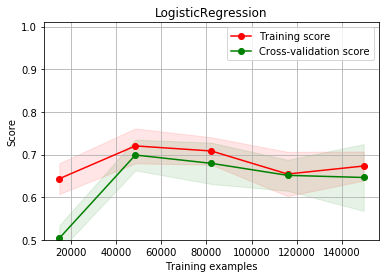

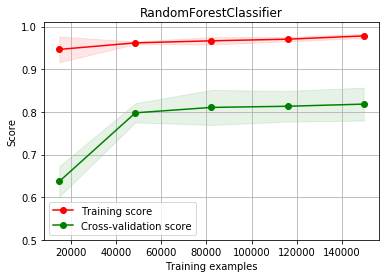

In [33]:
cv=StratifiedKFold(n_splits=4, random_state=2019, shuffle=True)

for m in [LogisticRegression(random_state=2019), 
          RandomForestClassifier(random_state=2019)]:
    plot_learning_curve(m, X_cv, y_cv, ylim=(0.5, 1.01), cv=cv)

Learning curves shows that models using RandomForestClassifier is extremely overfitted. 
Only LogisticRegression curve looks correct. In case of RandomForestClassifier some regularization should be added, for example changing parameters. 

Basic hyperparameter tuning using GridSearchCV has been performed. As a result I've found paramaters which have been used in further analysis.

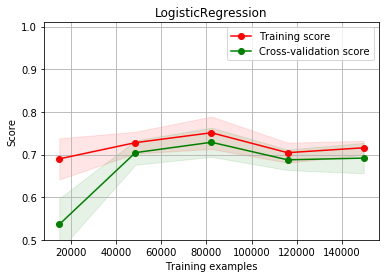

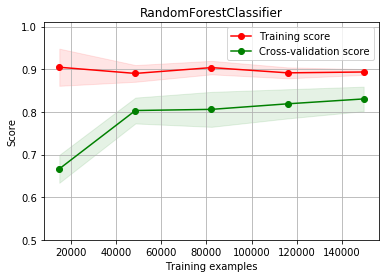

In [34]:
models=[LogisticRegression(solver='lbfgs', C=0.1, random_state=2019),
        RandomForestClassifier(max_depth=7, n_estimators=120, random_state=2019)]

cv=StratifiedKFold(n_splits=4, random_state=2019, shuffle=True)

for m in models:
    plot_learning_curve(m, X_cv, y_cv, ylim=(0.5, 1.01), cv=cv)

I've decided to consider only few parameters and check if it would have impact on overfitting. Results below shows that 
hyperparameter tuning has helped and models are less overfitted. Nevertheless curve for RandomForestClassifier is still not optimal.

Let's perform cross validation again, this time on models with tuned parameters.

In [35]:
black_list=['Class','Amount','Time']
features=[x for x in df.columns if x not in black_list ]

X_cv = train.loc[:,features]
y_cv = train.loc[:,'Class']

models=[RandomForestClassifier(max_depth=7, n_estimators=120, random_state=2019),
        LogisticRegression(solver='lbfgs', C=0.1, random_state=2019)]

print('     Model      (recall, precision, f1)  ')
for m in models:
    print(type(m).__name__,' ',my_cv(m, X_cv, y_cv))

     Model      (recall, precision, f1)  
RandomForestClassifier   (0.753, 0.927, 0.83)
LogisticRegression   (0.645, 0.812, 0.716)


#### Validation 

In [36]:
def validation(model, df_train=None, df_test=None,  matrix=True):
    
    black_list=['Class','Amount','Time']
    features=[x for x in df.columns if x not in black_list ]   
    X = df_train.loc[:,features].values 
    y = df_train['Class'].values
 
    X_test = df_test.loc[:,features].values
    y_test = df_test['Class'].values
    
    print(type(model).__name__)
    
    model.fit(X,y)
    y_pred=model.predict(X_test)

    if matrix==True:
        print('confusion matrix','\n',confusion_matrix(y_test,y_pred))    
        
    rec=np.round(recall_score(y_test,y_pred),3)
    prec=np.round(precision_score(y_test,y_pred),3)
    f1=np.round(f1_score(y_test,y_pred),3)
    
    return rec, prec, f1   

In [37]:
for m in models:
    print('(rec, prec, f1)',validation(m, train, test),'\n')

RandomForestClassifier
confusion matrix 
 [[85289     6]
 [   37   111]]
(rec, prec, f1) (0.75, 0.949, 0.838) 

LogisticRegression
confusion matrix 
 [[85269    26]
 [   42   106]]
(rec, prec, f1) (0.716, 0.803, 0.757) 



Results are even better than in cross validation. 
RandomForestClassifier achieved better results, but we should remember about problem of overfitting.

#### Precision recall curves

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    
    plt.axis([0, 1, 0, 1])

RandomForestClassifier


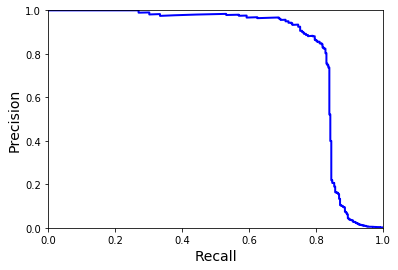

LogisticRegression


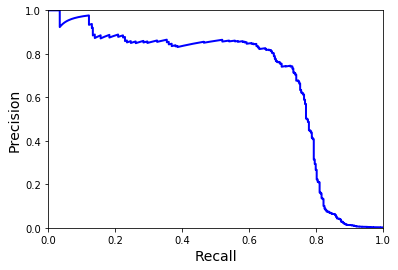

In [39]:
for m in models:
    y_predict=cross_val_predict(m,X_cv, y_cv,cv=4,method='predict_proba')
    y_pred=y_predict[:,-1]
    
    precisions, recalls,thresholds = precision_recall_curve(y_cv,y_pred) 
    
    plt.figure(figsize=(6, 4))
    print(type(m).__name__)
    
    plot_precision_vs_recall(precisions, recalls)
    plt.show()

Curves shows that in both cases we can achieve about 80% recall without losing precision. If we want more it is necessary to choose between one of this scores. There is also possibility to manipulate with threshold which is used by algorithm to make decision. Let's look on curves presenting dependency between precision, recall and threshold

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(loc="down right", fontsize=10)

RandomForestClassifier


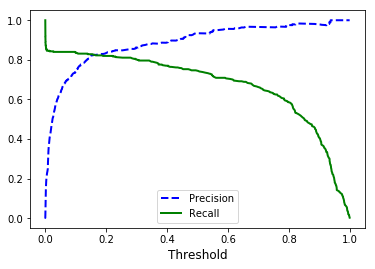

LogisticRegression


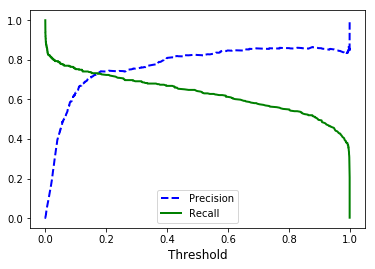

In [41]:
for m in models:
    y_predict = cross_val_predict(m, X_cv, y_cv, cv=4, method='predict_proba')
    y_pred = y_predict[:,-1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_cv, y_pred)  
    
    plt.figure(figsize=(6, 4))
    print(type(m).__name__)
    
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()

Default threshold is 0.5. According to curves, limiting threshold may result in higher recall, it is connected with loss of precision. 

####  ROC curve

In [42]:
def plot_roc_curve(fpr, tpr, label=None):  
    
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.axis([0, 1, 0, 1])
    
    plt.xlabel('False positive rate', fontsize=13)
    plt.ylabel('True positive rate', fontsize=13)

RandomForestClassifier
roc auc score: 97.02%


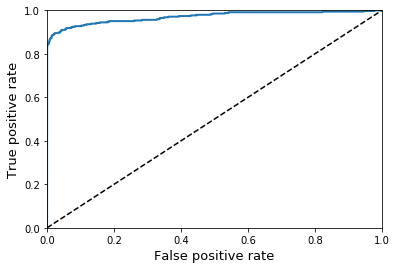

LogisticRegression
roc auc score: 95.25%


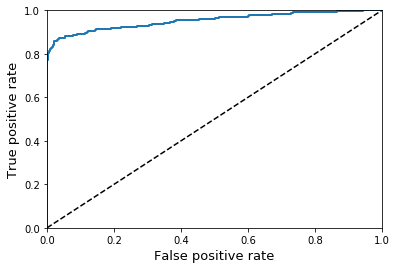

In [43]:
for m in models:
    y_predict=cross_val_predict(m,X_cv, y_cv,cv=4,method='predict_proba')
    y_pred=y_predict[:,-1]
    
    fpr, tpr, thresholds = roc_curve(y_cv,y_pred) 
    
    plt.figure(figsize=(6, 4))
    print(type(m).__name__)
    print('roc auc score: {}%' .format(round(roc_auc_score(y_cv,y_pred)*100,2)))
    
    plot_roc_curve(fpr, tpr)
    plt.show()

Roc curves looks pretty well, however when data is highly imbalanced, the results of this feature might be misleading. It is reasonable not to pay to much attention to this feature due to many true negative (non-fraud transactions).

### Undersampling

One of method which may be used working with imbalanced data is undersampling. In this part I random undersampling was perfromed in order to ensure same proportions between fraud and non-fraud data. 

In [44]:
number_fraud=len(train[train['Class']==1])

fraud_idx = train[train['Class']==1].index
normal_idx = train[train['Class']==0].index

np.random.seed(2019)
normal_idx_random = np.random.choice(normal_idx, number_fraud, replace=False)

und_idx = np.concatenate([fraud_idx, normal_idx_random])
np.random.shuffle(und_idx)

und_df = train.iloc[und_idx,:]

In [45]:
print('Percent of fraud transactions in undersampled set: {}%'.format(round(und_df['Class'].value_counts(normalize=True)[1]*100,2)))
print('Percent of non fraud transactions in undersampled set: {}%'.format(round(und_df['Class'].value_counts(normalize=True)[0]*100,2)))

print('Number of fraud transactions in undersampled set: {}'.format(und_df['Class'].value_counts(normalize=False)[1]))
print('Number of non fraud transactions in undersampled set: {}'.format(und_df['Class'].value_counts(normalize=False)[0]))

Percent of fraud transactions in undersampled set: 50.0%
Percent of non fraud transactions in undersampled set: 50.0%
Number of fraud transactions in undersampled set: 344
Number of non fraud transactions in undersampled set: 344


In [46]:
black_list=['Class','Time','Amount']
features=[x for x in und_df.columns if x not in black_list ]
X = und_df.loc[:,features].values 
y = und_df['Class'].values

models=[LogisticRegression(random_state=2019),
        RandomForestClassifier(random_state=2019)]

print('     Model      (accuracy, recall, precision, f1)  ')
for m in models:
    print(type(m).__name__,train_and_predict(m, X, y, test_size=0.3))

     Model      (accuracy, recall, precision, f1)  
LogisticRegression (0.952, 0.957, 0.938, 0.947)
RandomForestClassifier (0.961, 0.936, 0.978, 0.957)


Results looks very optimistic however taking into consideration that data sample is very small there 
is a high risk of overfitting.
In order to perform cross validation properly, I've prepared function in which undersampling is performing after 
splitting data into train and test. 

In [47]:
def undersampling(xc, yc):  
    
    number_fraud = len(xc[yc==1]) 
    
    fraud_idx = xc[yc==1].index
    normal_idx = xc[yc==0].index 
    
    np.random.seed(2019)
    normal_idx_random = np.random.choice(normal_idx,number_fraud,replace=False)
    
    und_idx = np.concatenate([fraud_idx,normal_idx_random])
    np.random.shuffle(und_idx)  
    
    return xc.loc[und_idx], yc[und_idx]

In [48]:
def cv_undersampling (m, xc, yc):
    
    cv = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True)    
    scores_r = []
    scores_p = []
    
    for train_idx, test_idx in cv.split(xc,yc):      
        x_tr=xc.loc[train_idx]
        y_tr=yc.loc[train_idx]
        x_t=xc.loc[test_idx]
        y_t=yc.loc[test_idx]
        
        x, y = undersampling(x_tr, y_tr)      
        model = clone(m)
        model.fit(x, y)
        y_pred = model.predict(x_t)
        
        score_r = recall_score(y_t, y_pred)
        score_p = precision_score(y_t, y_pred)    
        scores_r.append(score_r)
        scores_p.append(score_p)   
        
    return (round(np.mean(scores_r),3)),(round(np.mean(scores_p),3))

In [49]:
black_list=['Class','Time','Amount']
features=[x for x in df.columns if x not in black_list ]
X_cv = train.loc[:,features]
y_cv = train.loc[:,'Class']

for m in [RandomForestClassifier(max_depth=9, n_estimators=110, random_state=2019),
          LogisticRegression(C=0.1,random_state=2019)]:
    print(type(m).__name__,'(recall, precision)',cv_undersampling(m, X_cv, y_cv),)

RandomForestClassifier (recall, precision) (0.895, 0.064)
LogisticRegression (recall, precision) (0.901, 0.047)


The result above are more reliable. Precision is very small. It is caused by udersampling. In validation set proportions of values are different than during training. Recall is much higher than during validation on full data set but models qualify many transactions as fraud when in fact they are normal. 

Let's check on validation data.

In [50]:
for m in [RandomForestClassifier(max_depth=7, n_estimators=110, random_state=2019),
          LogisticRegression(C=0.1, random_state=2019)]:
    print('(rec,prec,f1)',validation(m, und_df, test),'\n')

RandomForestClassifier
confusion matrix 
 [[84301   994]
 [   19   129]]
(rec,prec,f1) (0.872, 0.115, 0.203) 

LogisticRegression
confusion matrix 
 [[83097  2198]
 [   15   133]]
(rec,prec,f1) (0.899, 0.057, 0.107) 



Models are characterized by very high recall. Unfortunately, as it was expected all models have small precsion - a lot of transactions are incorectly classified as frauds. If we need high recall and loss of precision is acceptable, this approach might be worth considering. It is also important in some cases that this technique is computionally efficient. 

### Oversampling - SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

Smote is a technique in which new synthetic points from minority class are beeing created in order to ensure balance between classes. As a result of SMOTE transformation we get bigger data set.

In [51]:
Xs = train.loc[:,features].values 
ys = train['Class'].values

smote = SMOTE(random_state=2019, sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_sample(Xs, ys)

In [52]:
train_overs = pd.DataFrame(data=np.concatenate([X_resampled, y_resampled.reshape(-1,1)], axis=1), columns=features+['Class'])

print('Number of fraud in undersampled set: {}'.format(len(X_resampled[y_resampled==1])))
print('Number of non fraud in undersampled set: {}'.format(len(X_resampled[y_resampled==0])))

Number of fraud in undersampled set: 199020
Number of non fraud in undersampled set: 199020


After oversampling with SMOTE there are 199 020 fraud transactions in dataset. It is important to remember that most of them are not real so it reasonable to be cautious.

In [53]:
def my_cv_os (m, xc, yc):
    
    cv = StratifiedKFold(n_splits=5, random_state=2019, shuffle=True) 
    scores_r = []
    scores_p = []
    
    for train_idx, test_idx in cv.split(xc,yc):        
        x_tr=xc.loc[train_idx]
        y_tr=yc.loc[train_idx]
        x_t=xc.loc[test_idx]
        y_t=yc.loc[test_idx]
        
        method = SMOTE(random_state=2019)
        X_resampled, y_resampled = method.fit_sample(x_tr, y_tr)
        model=clone(m)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(x_t)        
        
        score1 = recall_score(y_t, y_pred)
        score2 = precision_score(y_t, y_pred)       
        scores_r.append(score1)
        scores_p.append(score2)   
        
    return (round(np.mean(scores_r),3),round(np.mean(scores_p),3))

In [54]:
models=[RandomForestClassifier(max_depth=9, n_estimators=120, random_state=2019),
        LogisticRegression(solver='lbfgs', C=0.1, random_state=2019)]

In [55]:
black_list=['Class','Time','Amount']
features=[x for x in df.columns if x not in black_list ]

X_cv = train.loc[:,features]
y_cv = train.loc[:,'Class']

for m in models:
    print(type(m).__name__,' (recall, precision) ', my_cv_os(m, X_cv, y_cv))

RandomForestClassifier  (recall, precision)  (0.852, 0.531)
LogisticRegression  (recall, precision)  (0.892, 0.076)


This technique allows to achieve higher precision than in undersampling with small loss of recall. 

#### Validation

In [56]:
for m in models:
    print('(rec, prec, f1)',validation(m, train_overs, test),'\n')

RandomForestClassifier
confusion matrix 
 [[85191   104]
 [   21   127]]
(rec, prec, f1) (0.858, 0.55, 0.67) 

LogisticRegression
confusion matrix 
 [[83375  1920]
 [   19   129]]
(rec, prec, f1) (0.872, 0.063, 0.117) 



Classificators still have high recall. The number of false positive is lower than in undersampling - precision is significantly higher (especially in case of RandomForestClassifier - increase from 12% to 55%).
Models have omitted some fraud transactions - recall is smaller than using undersampling (about 2-5% decrease).

##  <center> Summary of validation results  

![title](img/res2.png)

#### Conslusions: 
- all techniques have some advantages and disadvantages - choice of approach should be performed very carefully and should be based on clearly precised business requirements
- working with such data is tricky, it is important to plan apropriate validation techniques
- risk of overfitting in working with imbalanced data is very high


#### To do:
- pay more attention to hyperparameter tuning, use hyperopt or scikit optimize
- try to combine algorithms, for example logistic regression and random forests
- try to remove outliers
- more feature engineering